In [59]:
import dask.dataframe as dd 
import numpy as np
from sklearn.preprocessing import LabelEncoder,RobustScaler
import seaborn as sns
import featuretools as ft
from dask.distributed import Client
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score,roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from utils import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
bureau = dd.read_csv("../data/bureau.csv").compute()
a = bureau.shape
print("bureau shape :({},{})".format( a[0],a[1]))

bureau_balance= dd.read_csv("../data/bureau_balance.csv").compute()
a = bureau_balance.shape
print("bureau_balance shape :({},{})".format( a[0],a[1]))

credit_card_balance= dd.read_csv("../data/credit_card_balance.csv").compute()
a = credit_card_balance.shape
print("credit_card_balance shape :({},{})".format( a[0],a[1]))

installments_payments= dd.read_csv("../data/installments_payments.csv").compute()
a = installments_payments.shape
print("installments_payments shape :({},{})".format( a[0],a[1]))

previous_application= dd.read_csv("../data/previous_application.csv").compute()
a = previous_application.shape
print("previous_application shape :({},{})".format( a[0],a[1]))

POS_CASH_balance= dd.read_csv("../data/POS_CASH_balance.csv").compute()
a = POS_CASH_balance.shape
print("POS_CASH_balance shape :({},{})".format( a[0],a[1]))

application_train= dd.read_csv("../data/application_train.csv").compute()
a = application_train.shape
print("application_train shape :({},{})".format( a[0],a[1]))

application_test= dd.read_csv("../data/application_test.csv").compute()
a = application_test.shape
print("application_test shape :({},{})".format( a[0],a[1]))

bureau shape :(1716428,17)
bureau_balance shape :(27299925,3)
credit_card_balance shape :(3840312,23)
installments_payments shape :(13605401,8)
previous_application shape :(1670214,37)
POS_CASH_balance shape :(10001358,8)
application_train shape :(307511,122)
application_test shape :(48744,121)


* Preprocessing

In [3]:
bureau_balance["MONTHS_BALANCE"]=np.abs(bureau_balance["MONTHS_BALANCE"])
bureau_balance['STATUS']=bureau_balance['STATUS'].apply(lambda x: 'Y' if x in ['5', '1', '4', '3','0', '2'] else x)
# bureau_balance=dd.get_dummies(bureau_balance,columns=['STATUS'],drop_first=True)

In [4]:
bureau_balance=reduce_mem_usage(bureau_balance)

Mem. usage decreased to 546.74 Mb (34.4% reduction)


In [5]:
bureau[bureau['DAYS_ENDDATE_FACT']<-40000]['DAYS_ENDDATE_FACT']=np.nan
bureau[bureau['DAYS_CREDIT_UPDATE']<-40000]['DAYS_CREDIT_UPDATE']=np.nan
bureau[bureau['AMT_CREDIT_MAX_OVERDUE']>.8e8]['AMT_CREDIT_MAX_OVERDUE']=np.nan
bureau[bureau['AMT_CREDIT_SUM']>5e8]['AMT_CREDIT_SUM']=np.nan
bureau[bureau['AMT_CREDIT_SUM_DEBT']>1.5e8]['AMT_CREDIT_SUM_DEBT']=np.nan 
bureau[bureau['AMT_CREDIT_SUM_OVERDUE']>3.5e5]['AMT_CREDIT_SUM_OVERDUE']=np.nan 
bureau[bureau['AMT_ANNUITY']>1e8]['AMT_ANNUITY']=np.nan

In [6]:
bureau.fillna(0,inplace=True)

In [7]:
# bureau=dd.get_dummies(bureau,drop_first=True)

In [8]:
bureau=reduce_mem_usage(bureau)

Mem. usage decreased to 126.04 Mb (46.5% reduction)


In [9]:
application_train=cleaning(application_train)
# application_train=dd.get_dummies(application_train,drop_first=True)

Mem. usage decreased to 94.72 Mb (67.2% reduction)


In [10]:
POS_CASH_balance['MONTHS_BALANCE']=np.abs(POS_CASH_balance['MONTHS_BALANCE'])
POS_CASH_balance['SK_DPD'] = POS_CASH_balance['SK_DPD'].apply( lambda x: 1 if x>0 else 0)

In [11]:
POS_CASH_balance.fillna(0,inplace=True)
# POS_CASH_balance=dd.get_dummies(POS_CASH_balance,drop_first=True)
POS_CASH_balance=reduce_mem_usage(POS_CASH_balance)

Mem. usage decreased to 305.22 Mb (55.6% reduction)


In [12]:
credit_card_balance['MONTHS_BALANCE']=np.abs(credit_card_balance['MONTHS_BALANCE'])
credit_card_balance['SK_DPD'] = credit_card_balance['SK_DPD'].apply( lambda x: 1 if x>0 else 0)
credit_card_balance.fillna(0,inplace=True)

In [13]:
# credit_card_balance=dd.get_dummies(credit_card_balance,drop_first=True)
credit_card_balance=reduce_mem_usage(credit_card_balance)

Mem. usage decreased to 314.97 Mb (55.2% reduction)


In [14]:
installments_payments['LATE_PAYMENT_FLAG'] = (installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']).apply(lambda x: 1 if x>0 else 0)
installments_payments['LESS_PAYMENT_FLAG'] = (installments_payments['AMT_PAYMENT'] - installments_payments['AMT_INSTALMENT']).apply(lambda x: 1 if x>0 else 0)

In [15]:
installments_payments.fillna(0,inplace=True)
installments_payments=reduce_mem_usage(installments_payments)

Mem. usage decreased to 441.15 Mb (61.4% reduction)


In [16]:
previous_application['DAYS_FIRST_DRAWING'][previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
previous_application['DAYS_FIRST_DUE'][previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
previous_application['DAYS_LAST_DUE_1ST_VERSION'][previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
previous_application['DAYS_LAST_DUE'][previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
previous_application['DAYS_TERMINATION'][previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
previous_application['AMT_APPLICATION'][previous_application['AMT_APPLICATION'] > 5e6] = np.nan

In [17]:
categorical=previous_application.select_dtypes('object').columns
numeric=previous_application.select_dtypes('number').columns

In [18]:
for i in categorical:
    previous_application[i]=previous_application[i].fillna(previous_application[i].mode()[0]) 

In [19]:
for i in numeric:
    if(previous_application[i].mean()==np.nan):
        previous_application[i]=previous_application[i].fillna(previous_application[i].mean())
    else : 
        previous_application[i]=previous_application[i].fillna(0)

In [20]:
# previous_application=dd.get_dummies(previous_application,drop_first=True)
previous_application=reduce_mem_usage(previous_application)

Mem. usage decreased to 305.83 Mb (36.8% reduction)


* Features Tools

In [21]:
es = ft.EntitySet(id="application")

In [22]:
es = es.add_dataframe(dataframe_name="bureau",
                              dataframe=bureau,
                              index="SK_ID_BUREAU" )

In [23]:
es = es.add_dataframe(dataframe_name="bureau_balance",
                              dataframe=bureau_balance,
                              index="index")

In [24]:
es = es.add_dataframe(dataframe_name="application_train",
                              dataframe=application_train,
                              index="SK_ID_CURR")

In [25]:
es = es.add_dataframe(dataframe_name="previous_application",
                              dataframe=previous_application,
                              index="index")

In [26]:
es = es.add_dataframe(dataframe_name="pos_cash_balance",
                              dataframe=POS_CASH_balance,
                              index="index")

In [27]:
es = es.add_dataframe(dataframe_name="installments_payments",
                              dataframe=installments_payments,
                              index="index")

In [28]:
es = es.add_dataframe(dataframe_name="credit_card_balance",
                              dataframe=credit_card_balance,
                              index="index")

In [29]:
es = es.add_relationship("bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU")

In [30]:
es = es.add_relationship("application_train", "SK_ID_CURR", "bureau", "SK_ID_CURR")

In [31]:
es = es.add_relationship("application_train", "SK_ID_CURR", "installments_payments", "SK_ID_CURR")

In [32]:
es = es.add_relationship("application_train", "SK_ID_CURR", "credit_card_balance", "SK_ID_CURR")

In [33]:
es = es.add_relationship("application_train", "SK_ID_CURR", "pos_cash_balance", "SK_ID_CURR")

In [34]:
es = es.add_relationship("application_train", "SK_ID_CURR", "previous_application", "SK_ID_CURR")

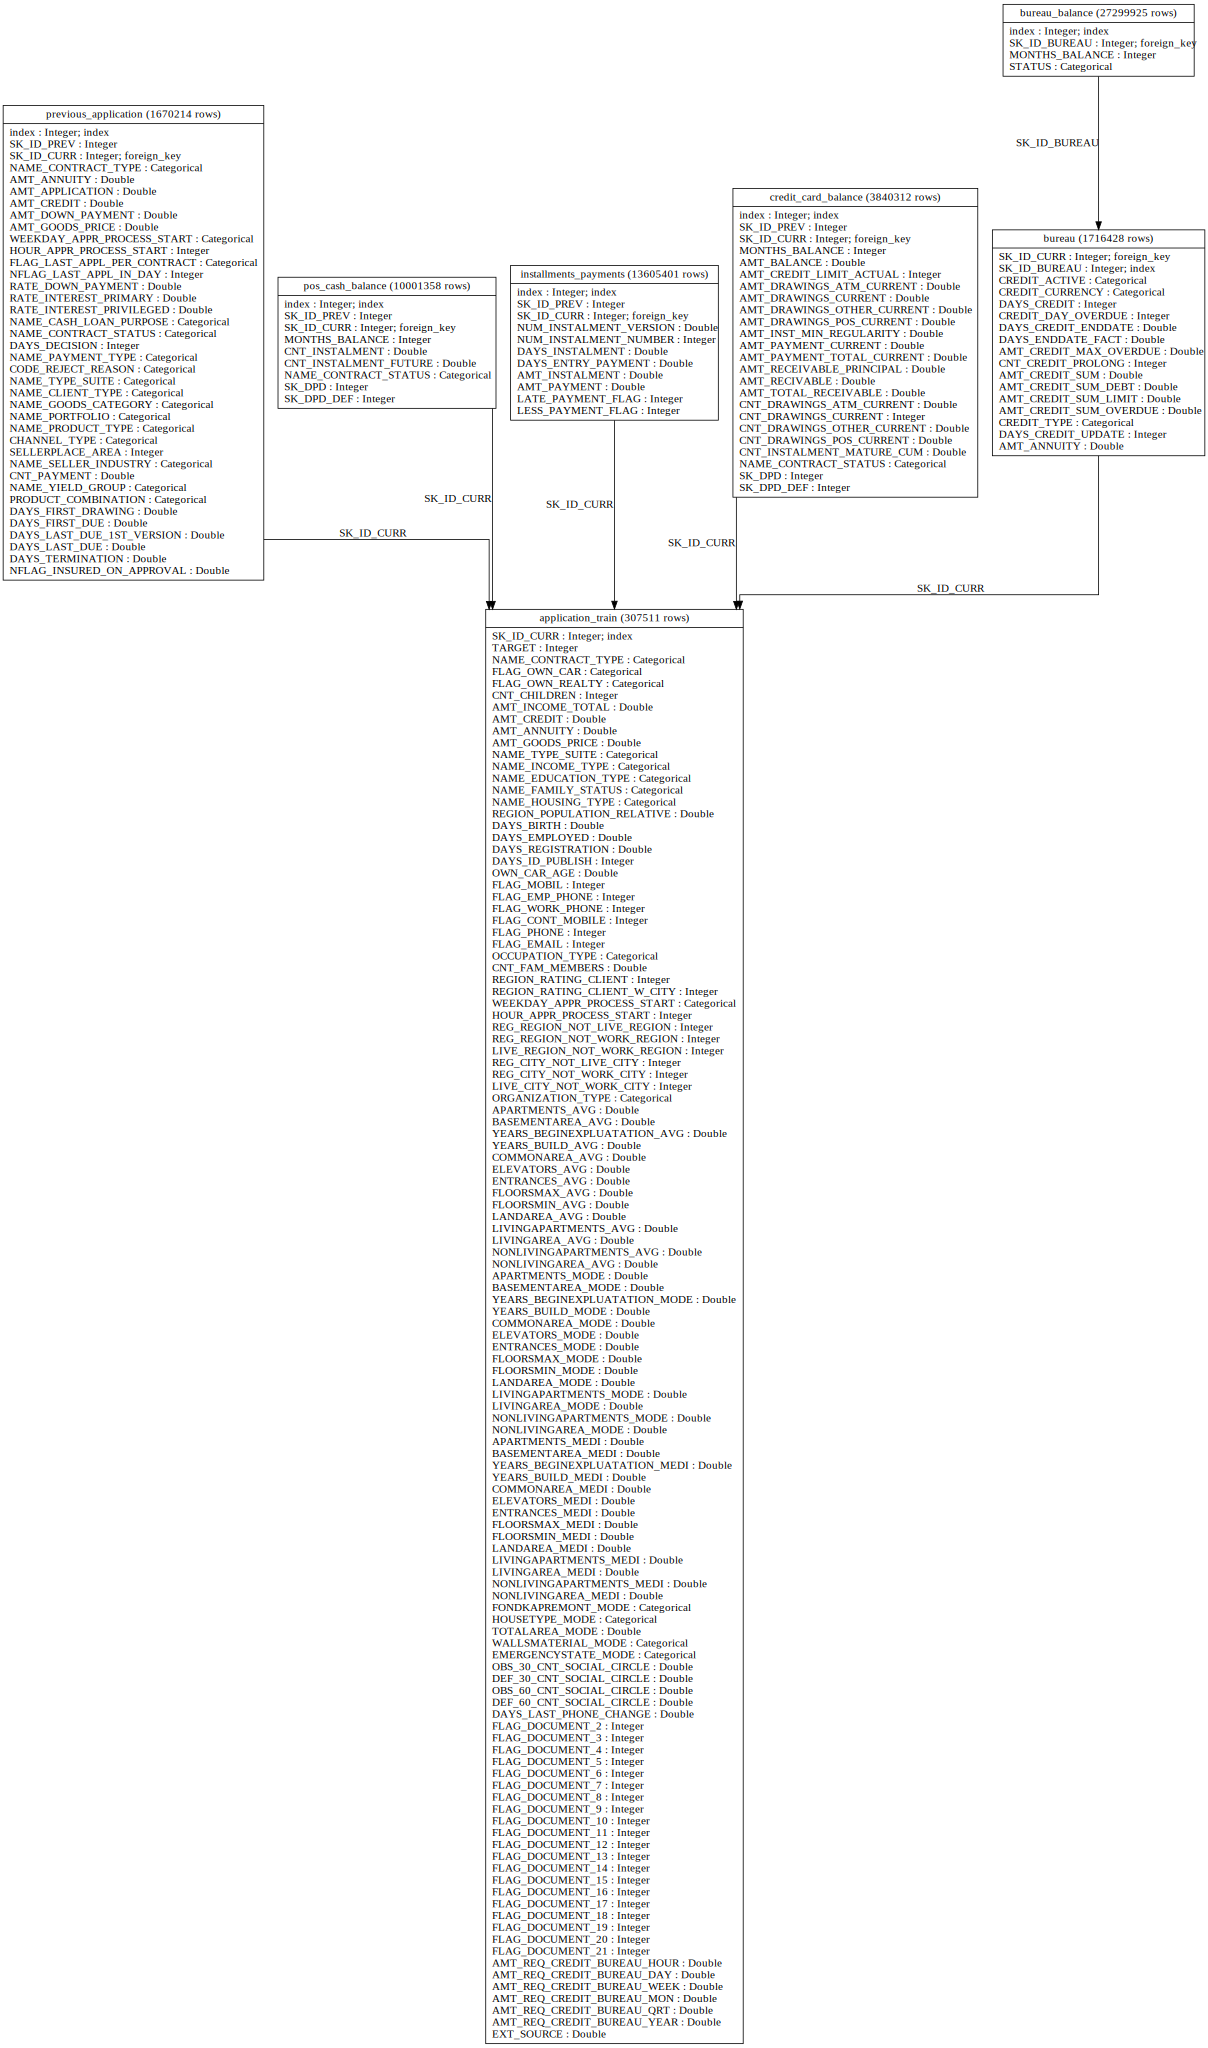

In [35]:
es.plot()

In [36]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name="application_train")

In [37]:
feature_matrix

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,SUM(bureau_balance.bureau.AMT_CREDIT_SUM),SUM(bureau_balance.bureau.AMT_CREDIT_SUM_DEBT),SUM(bureau_balance.bureau.AMT_CREDIT_SUM_LIMIT),SUM(bureau_balance.bureau.AMT_CREDIT_SUM_OVERDUE),SUM(bureau_balance.bureau.CNT_CREDIT_PROLONG),SUM(bureau_balance.bureau.CREDIT_DAY_OVERDUE),SUM(bureau_balance.bureau.DAYS_CREDIT),SUM(bureau_balance.bureau.DAYS_CREDIT_ENDDATE),SUM(bureau_balance.bureau.DAYS_CREDIT_UPDATE),SUM(bureau_balance.bureau.DAYS_ENDDATE_FACT)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
0,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,0,Cash loans,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,1.782000e+07,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-32439.0,3696.0,-231.0,0.0
307508,0,Cash loans,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
feature_matrix.to_csv('feature_matrix.csv',index=False)

In [39]:
# feature_matrix=reduce_mem_usage(feature_matrix)

In [40]:
feature_matrix.isna().count().sum()

216487744

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
# feature_matrix=dd.read_csv('feature_matrix.csv')

In [45]:
def preprocessing(df):
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']

    return X, y

In [98]:
feature_matrix_copy=feature_matrix.copy()

In [99]:
cat_feature_list=feature_matrix_copy.select_dtypes('category').columns.values

In [100]:
for i in feature_matrix.columns.values:
    if i not in cat_feature_list:
        model=RobustScaler()
        feature_matrix_copy[i]=model.fit_transform(feature_matrix_copy[[i]])
    else :
        model=LabelEncoder()
        feature_matrix_copy[i]=model.fit_transform(feature_matrix_copy[[i]])




In [104]:
X,y=preprocessing(feature_matrix_copy)

In [105]:
feature_matrix_copy.fillna(0,inplace=True)

In [108]:
rfc=RandomForestClassifier()
rfc.fit(X,y)

RandomForestClassifier()

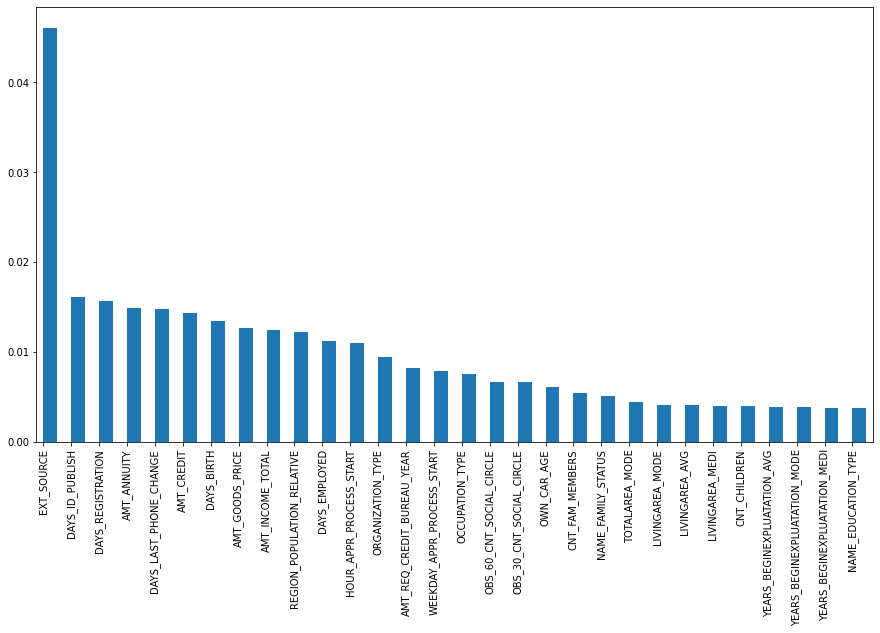

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
feature_importance= pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

In [110]:
# import joblib 
# filename = 'finalized_model.sav'
# joblib.dump(rfc, filename)

['finalized_model.sav']

In [2]:
data=dd.read_csv('feature_matrix.csv',dtype={'MODE(bureau.CREDIT_ACTIVE)': 'object',
       'MODE(bureau.CREDIT_CURRENCY)': 'object',
       'MODE(bureau.CREDIT_TYPE)': 'object',
       'MODE(bureau.MODE(bureau_balance.STATUS))': 'object',
       'MODE(bureau_balance.STATUS)': 'object',
       'MODE(bureau_balance.bureau.CREDIT_ACTIVE)': 'object',
       'MODE(bureau_balance.bureau.CREDIT_CURRENCY)': 'object',
       'MODE(bureau_balance.bureau.CREDIT_TYPE)': 'object',
       'MODE(credit_card_balance.NAME_CONTRACT_STATUS)': 'object',
       'MODE(pos_cash_balance.NAME_CONTRACT_STATUS)': 'object',
       'MODE(previous_application.CHANNEL_TYPE)': 'object',
       'MODE(previous_application.CODE_REJECT_REASON)': 'object',
       'MODE(previous_application.FLAG_LAST_APPL_PER_CONTRACT)': 'object',
       'MODE(previous_application.NAME_CASH_LOAN_PURPOSE)': 'object',
       'MODE(previous_application.NAME_CLIENT_TYPE)': 'object',
       'MODE(previous_application.NAME_CONTRACT_STATUS)': 'object',
       'MODE(previous_application.NAME_CONTRACT_TYPE)': 'object',
       'MODE(previous_application.NAME_GOODS_CATEGORY)': 'object',
       'MODE(previous_application.NAME_PAYMENT_TYPE)': 'object',
       'MODE(previous_application.NAME_PORTFOLIO)': 'object',
       'MODE(previous_application.NAME_PRODUCT_TYPE)': 'object',
       'MODE(previous_application.NAME_SELLER_INDUSTRY)': 'object',
       'MODE(previous_application.NAME_TYPE_SUITE)': 'object',
       'MODE(previous_application.NAME_YIELD_GROUP)': 'object',
       'MODE(previous_application.PRODUCT_COMBINATION)': 'object',
       'MODE(previous_application.WEEKDAY_APPR_PROCESS_START)': 'object'}).compute()

In [3]:
data

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,SUM(bureau_balance.bureau.AMT_CREDIT_SUM),SUM(bureau_balance.bureau.AMT_CREDIT_SUM_DEBT),SUM(bureau_balance.bureau.AMT_CREDIT_SUM_LIMIT),SUM(bureau_balance.bureau.AMT_CREDIT_SUM_OVERDUE),SUM(bureau_balance.bureau.CNT_CREDIT_PROLONG),SUM(bureau_balance.bureau.CREDIT_DAY_OVERDUE),SUM(bureau_balance.bureau.DAYS_CREDIT),SUM(bureau_balance.bureau.DAYS_CREDIT_ENDDATE),SUM(bureau_balance.bureau.DAYS_CREDIT_UPDATE),SUM(bureau_balance.bureau.DAYS_ENDDATE_FACT)
0,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15274,0,Cash loans,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15275,0,Cash loans,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,1.782000e+07,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-32439.0,3696.0,-231.0,0.0
15276,0,Cash loans,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15277,1,Cash loans,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,...,1.643911e+08,2.170479e+07,1.353745e+06,0.0,0.0,0.0,-505409.0,-193.0,-120454.0,-62860.0


In [3]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(to_drop,axis=1,inplace=True)

In [4]:
data.shape

(307511, 489)

In [5]:
data.to_csv('feature_matrix1.csv',index=False)

In [86]:
data=dd.read_csv('feature_matrix1.csv',dtype={'MODE(bureau.CREDIT_ACTIVE)': 'object',
       'MODE(bureau.CREDIT_CURRENCY)': 'object',
       'MODE(bureau.CREDIT_TYPE)': 'object',
       'MODE(bureau.MODE(bureau_balance.STATUS))': 'object',
       'MODE(bureau_balance.STATUS)': 'object',
       'MODE(bureau_balance.bureau.CREDIT_ACTIVE)': 'object',
       'MODE(bureau_balance.bureau.CREDIT_CURRENCY)': 'object',
       'MODE(bureau_balance.bureau.CREDIT_TYPE)': 'object',
       'MODE(credit_card_balance.NAME_CONTRACT_STATUS)': 'object',
       'MODE(pos_cash_balance.NAME_CONTRACT_STATUS)': 'object',
       'MODE(previous_application.CHANNEL_TYPE)': 'object',
       'MODE(previous_application.CODE_REJECT_REASON)': 'object',
       'MODE(previous_application.FLAG_LAST_APPL_PER_CONTRACT)': 'object',
       'MODE(previous_application.NAME_CASH_LOAN_PURPOSE)': 'object',
       'MODE(previous_application.NAME_CLIENT_TYPE)': 'object',
       'MODE(previous_application.NAME_CONTRACT_STATUS)': 'object',
       'MODE(previous_application.NAME_CONTRACT_TYPE)': 'object',
       'MODE(previous_application.NAME_GOODS_CATEGORY)': 'object',
       'MODE(previous_application.NAME_PAYMENT_TYPE)': 'object',
       'MODE(previous_application.NAME_PORTFOLIO)': 'object',
       'MODE(previous_application.NAME_PRODUCT_TYPE)': 'object',
       'MODE(previous_application.NAME_SELLER_INDUSTRY)': 'object',
       'MODE(previous_application.NAME_TYPE_SUITE)': 'object',
       'MODE(previous_application.NAME_YIELD_GROUP)': 'object',
       'MODE(previous_application.PRODUCT_COMBINATION)': 'object',
       'MODE(previous_application.WEEKDAY_APPR_PROCESS_START)': 'object'}).compute()

In [87]:
categorical=data.select_dtypes('O').columns.values

In [88]:
numeric=list(data.select_dtypes('int64').columns.values)+list(data.select_dtypes('float64').columns.values)